In [1]:
import json

from tqdm.auto import tqdm
import pandas as pd
import jinja2
from dotenv import load_dotenv
from openai import OpenAI

import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv("../.env")
client = OpenAI()

In [2]:
df = pd.read_csv("../../data/itell-question-data-sampled.csv", index_col=0)
df

,id,response,score,condition,user_id,page_slug,chunk_slug,created_at,volume_slug,volume_title,page_title,chunk_header,chunk_text,question,answer
4139,38f590ee-1964-4a7c-9625-53b53cb8a9f0,learning,0,NaN,clu91tykw0002l00fz3o1vfsh,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-04-15 19:57:38.656,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens..."
4124,95784937-f565-4450-bfad-babc2399d667,answer,0,NaN,cluc0hclp0000ju0flnuywkrr,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-05-05 20:29:28.14,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens..."
4132,88c0f433-7fdb-48ad-9898-a08d861635e1,human observers made live annotations regardin...,0,NaN,clu7cooq9000kjt0fbxh29vfy,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-04-15 19:03:37.985,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens..."
4120,53c99817-a318-45e5-a918-6b2e7dd4e8d1,Recorded data from student while doing help ba...,0,NaN,clucz38h40005jv0fhc5vjpfp,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-03-30 01:56:12.488,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens..."
4128,9f3eeb88-7254-402f-b025-b3c0298e2a64,analyzing context,0,NaN,clu8uwkw20000jz0f4yyg6c1d,emotional,01-Affect-Detection-from-Student-Activity-Data...,2024-05-03 20:56:52.298,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,0.1 Affect Detection from Student Activity Data,Affective states cannot be directly measured b...,What approach was used to infer affect by anal...,"The interaction-based, log-file based, or sens..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2257,"Slow technological progress, natural disasters...",2,stairs,pkwlvvzebu2ppqvjop66x5hequ,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,2024-08-15 22:19:30.781007+00:00,cttc-poe,Principles of Macroeconomics,7.1 The Relatively Recent Arrival of Economic ...,learning objectives,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
135,1515,Economic conditions before 1870 were sluggish ...,2,stairs,mx25ylobcck2yg2xkiv4srpfh4,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,2024-08-12 18:03:45.775565+00:00,cttc-poe,Principles of Macroeconomics,7.1 The Relatively Recent Arrival of Economic ...,learning objectives,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
221,2458,economic conditions were slow,2,stairs,kwj3wlbqwnfecwceaxe2noulju,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-700t,2024-08-15 23:28:39.503359+00:00,cttc-poe,Principles of Macroeconomics,7.1 The Relatively Recent Arrival of Economic ...,learning objectives,Let’s begin with a brief overview of spectacul...,What were economic conditions like before 1870?,Economic conditions before 1870 were marked by...
245,2794,"Before 1870, economic conditions were relative...",2,stairs,dggh43s5cosnmyxo57zex3cucy,7-1-the-relatively-recent-arrival-of-economic-...,learning-objectives-70

## Data Distribution

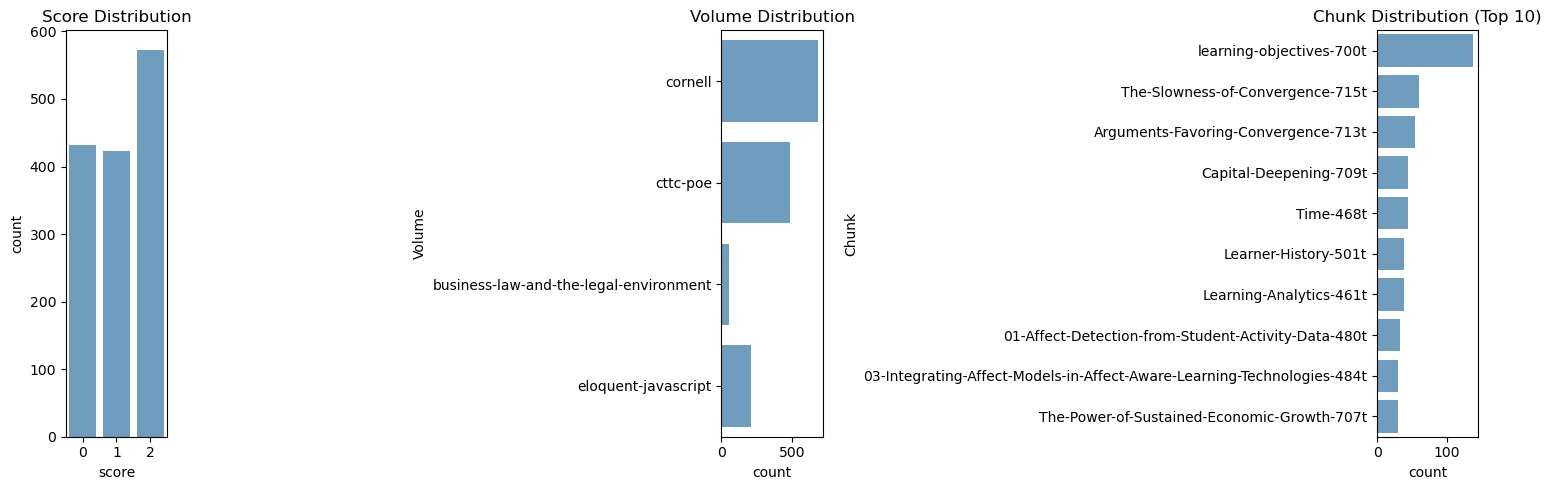

In [113]:
# Set up the plotting area
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot score distribution
sns.countplot(x='score', data=df, ax=axs[0], alpha=0.7)
axs[0].set_title('Score Distribution')

# Plot volume distributions
sns.countplot(y='volume_slug', data=df, ax=axs[1], alpha=0.7)
axs[1].set_title('Volume Distribution')
axs[1].set_ylabel('Volume')

# Plot chunk distributions (top N chunks for clarity)
top_chunks = df['chunk_slug'].value_counts().head(10).index
top_chunk_df = df[df['chunk_slug'].isin(top_chunks)]

sns.countplot(y='chunk_slug', data=top_chunk_df, order=top_chunks, ax=axs[2], alpha=0.7)
axs[2].set_title('Chunk Distribution (Top 10)')
axs[2].set_ylabel('Chunk')

plt.tight_layout()
plt.show();

## Test Prompt

In [116]:
environment = jinja2.Environment(loader=jinja2.FileSystemLoader("prompts"))
template = environment.get_template("response-score.jinja2")

print(template.render(df.sample(1).to_dict(orient="records")[0]))

You are an expert educational assessment evaluator. Your task is to score a student's short answer response based on a specific rubric.

SCORING RUBRIC:
Please score the student's response according to the following construct map. Examples for each level of response are provided in response to the following example question and example reference answer:

Example Question: "What are some examples of areas in which governments invest to facilitate capital deepening and technology?"
Example Reference Answer: "Education, savings and investment, infrastructure, special economic zones, and scientific research."

Level 4: Expert Reading
- Characteristics: Student demonstrates strong engagement with the text and full comprehension of the material.
- Response Quality: Demonstrates a command of the material and ability to manipulate concepts to form cohesive and detailed answers.
- Example of Level 4 Response: "Education, infrastructure, scientific research funding, and special economic zones ar

## Test Model Response

In [115]:
sample = df.sample(1)
print("Original Score: ", sample["score"].item())

response = client.chat.completions.create(
    model="o3-mini-2025-01-31",
    messages=[
        {
            "role": "user", 
            "content": template.render(sample.to_dict(orient="records")[0])
        }
    ],
    response_format={  # {"score": "1"}
        "type": "json_schema",
        "json_schema": {
            "name": "cri_score_schema",
            "schema": {
                "type": "object",
                "properties": {
                    "score": {
                        "description": "A single digit from 1-4 representing the score of the student's response",
                        "type": "integer"
                    },
                    "additionalProperties": False
                }
            }
        }
    }
)

score_dict_string = response.choices[0].message.content
score_dict = json.loads(score_dict_string)
score = score_dict["score"]
print(f"GPT Score: {score}")

Original Score:  1
GPT Score: 2


# Score data

In [117]:
responses = []

for row in tqdm(df.itertuples(), total=len(df)):
    response = client.chat.completions.create(
        model="o3-mini-2025-01-31",
        messages=[{
            "role": "user",
            "content": template.render(
                chunk_text = row.chunk_text,
                question = row.question,
                answer = row.answer,
                response = row.response,
            )
        }],
        response_format={  # {"score": "1"}
            "type": "json_schema",
            "json_schema": {
                "name": "cri_score_schema",
                "schema": {
                    "type": "object",
                    "properties": {
                        "score": {
                            "description": "A single digit from 1-4 representing the score of the student's response",
                            "type": "integer"
                        },
                        "additionalProperties": False
                    }
                }
            }
        }
    )
    responses.append(response)

  0%|          | 0/1428 [00:00<?, ?it/s]

In [118]:
scores = [
    json.loads(response.choices[0].message.content)["score"]
    for response in responses
]

df["o3_mini_score"] = scores

df.sample(3)

,id,response,score,condition,user_id,page_slug,chunk_slug,created_at,volume_slug,volume_title,page_title,chunk_header,chunk_text,question,answer,o3_mini_score
2871,3be7dca7-5d8e-4f70-b7ff-2c421270f74e,The models were generalizable to different gro...,1,NaN,cludd41ph0000jn0ferggc8t0,emotional,Core-Themes-2-479t,2024-03-30 02:53:18.51,cornell,Handbook of Learning Analytics,Emotional Learning Analytics,Core Themes 2,"Further, San Pedro, Baker, Bowers, & Heffernan...",What was a significant finding in the study by...,Automatically measured affective states were s...,1
2150,c47888d9-e96e-49ca-af2b-501f464d1349,Jurisdictional requirement for cases involving...,0,NaN,clrca1hcm0000l40fwq1qfdoj,the-relationship-between-state-and-federal-cou...,introduction-322t,2024-02-19 17:36:11.401,business-law-and-the-legal-environment,Business Law and the Legal Environment,The Relationship between State and Federal Co...,introduction,Although it is sometimes said that there are t...,Why are there so many diversity cases in feder...,Defense lawyers believe that there is sometime...,2
4077,b498e334-5143-4fd4-a04a-cdab6b187209,for who? what data is visualized? what is the ...,1,NaN,clud2gdn0000hjv0fwra9053f,learning-an-1,How-to-Get-Started-Chunk-2-532t,2024-03-30 22:53:08.915,cornell,Handbook of Learning Analytics,Learning Analytics Dashboard,How to Get Started Chunk 2,"From these traces, we can define sev...",What type of questions are deliberately listed...,"Questions that start with 'what,' 'when,' 'how...",1


In [156]:
df[["score", "o3_mini_score"]].corr(method="spearman")

,score,o3_mini_score
score,1.000000,0.622661
o3_mini_score,0.622661,1.000000


In [119]:
df.to_csv("../../data/itell-question-data-w-o3-scores.csv", index=False)

In [120]:
df.groupby(["score", "o3_mini_score"]).size()

score  o3_mini_score
0      1                235
       2                181
       3                 14
       4                  2
1      1                 85
       2                213
       3                 84
       4                 41
2      1                 22
       2                171
       3                146
       4                234
dtype: int64

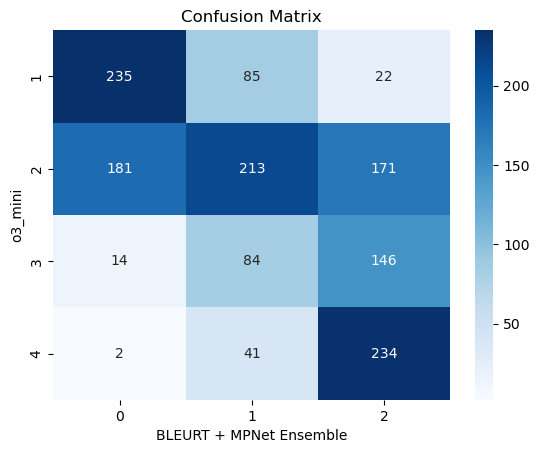

In [136]:
crosstab = pd.crosstab(
    df["o3_mini_score"],
    df["score"],
)

sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["0", "1", "2"],
            yticklabels=["1", "2", "3", "4"])
plt.ylabel("o3_mini")
plt.xlabel("BLEURT + MPNet Ensemble")
plt.title("Confusion Matrix")
plt.show()

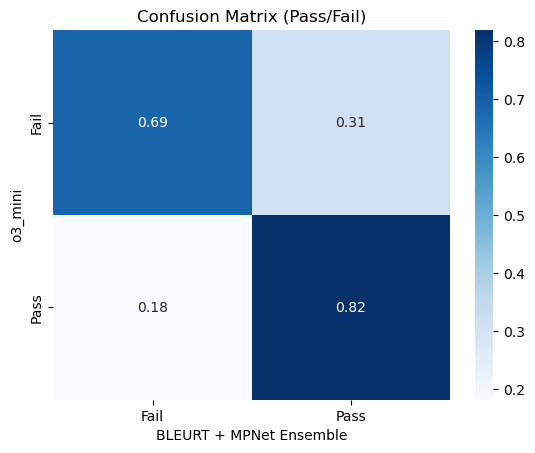

In [166]:
crosstab = pd.crosstab(
    df["o3_mini_score"] > 1,
    df["score"] > 0,
    normalize="index",
)

sns.heatmap(crosstab, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Fail", "Pass"],
            yticklabels=["Fail", "Pass"])

plt.xlabel("BLEURT + MPNet Ensemble")
plt.ylabel("o3_mini")
plt.title("Confusion Matrix (Pass/Fail)")
plt.show()

In [164]:
pd.crosstab(
    df["score"] > 0,
    df["o3_mini_score"] > 1,
    margins=True
)

o3_mini_score,False,True,All
score,,,
False,235,197,432
True,107,889,996
All,342,1086,1428


## Quick Analysis

It seems that o3 is almost always correct when it scores a response as "1" that was scored as passing by the BLEURT+MPNet ensemble. These are generally responses where the student uses a key phrase from the passage or the question but fails to answer the question accurately.

o3 scores of "2" are tricky. These are generally low-quality, short responses. I think it would be beneficial to consider a "conditional pass" feedback mechanism, where a single "2" score is accepted, but repeated scores of "2" will result in the user being prompted to right full and complete answers that include details from the text.

In [169]:
with pd.option_context('display.max_colwidth', 0):
    would_fail_with_o3 = (
        df
        .query("score == 0 & `o3_mini_score` == 2")
        .rename(columns={
            "question": "Question",
            "answer": "Reference Answer",
            "response": "Student Response",
        })
    )
    display(would_fail_with_o3[["Question", "Reference Answer", "Student Response"]].sample(10))

,Question,Reference Answer,Student Response
3281,What is the aim of affect-aware learning technologies like Affective AutoTutor?,The aim is to expand the adaptivity of current learning technologies by responding to what students feel in addition to what they think and do.,To help students develop mastery on difficult topics
2475,What are the five primitive cognitive operations that transform information in ways that cannot be further decomposed?,"searching, monitoring, assembling, rehearsing, and translating.",SMART
3355,Why is it important to incorporate emotion into the analysis of learning?,It has the unique potential to advance both the science of learning and the science of emotion.,they influence thoughts and behavior
178,What were economic conditions like before 1870?,"Economic conditions before 1870 were marked by slow technological progress, natural disasters, and institutions that played a critical role in determining income levels.",people could not afford as much food
37,What were economic conditions like before 1870?,"Economic conditions before 1870 were marked by slow technological progress, natural disasters, and institutions that played a critical role in determining income levels.","Low standard of living, Industrial revolution led to high inequalities of nation's GDP."
3971,What data should be gathered for input to methods used to generate learning analytics?,Data that can be used for computations and analysis to predict student progress and performance.,social connections
146,What were economic conditions like before 1870?,"Economic conditions before 1870 were marked by slow technological progress, natural disasters, and institutions that played a critical role in determining income levels.","Terrible, as many people were barely scrapping the st4andard of living"
62,What were economic conditions like before 1870?,"Economic conditions before 1870 were marked by slow technological progress, natural disasters, and institutions that played a critical role in determining income levels.",Equally bad around the world. Per Capita income levels hovered between $600-800 for nearly everyone (in current international dollar units)
4087,What type of questions are deliberately listed for both teachers and students in the design process?,"Questions that start with 'what,' 'when,' 'how much,' and 'how often.'",how miuch time spent
3775,What are learning analytics designed to do?,Learning analytics are designed to optimize learning and the environments in which it occurs.,Learning analytics are designed to support SRL
